## Hi Marta! 
#### This is a quick script to show you how to pull data from nxcals using Swan. 
#### Before running the code make sure to select the 'star' symbol in the tab and select include 'nxcals' and 'sparcmetrics' options.

In [41]:
# some packages for visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tfs

In [42]:
import sys
sys.path.append('/eos/home-i03/m/morwat/.local/lib/python3.9/site-packages/')

In [43]:
# import package to access Timber
import pytimber

# initialise the logging
ldb = pytimber.LoggingDB(spark_session=spark)

In [67]:
# you can pull data from a fill you are interested in
fill = 8634

# get the timestamps of different beam modes during chosen fill
fill_timestamps = ldb.get_lhc_fill_data(fill)
ffn = {item['mode']:item for item in fill_timestamps['beamModes']}

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/pytimber/utils.py:93: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [69]:
# define times of the mode you are interested in exploring
t1 = ffn['INJPHYS']['startTime']
t2 = ffn['INJPROB']['endTime']

In [70]:
# load the variable you are interested in
BPM_varname_H = 'BFC.LHC:OrbitAcq:positionsH'
BPM_varname_V = 'BFC.LHC:OrbitAcq:positionsV'

BPM_pos_H = ldb.get(BPM_varname_H, t1, t2)
BPM_pos_V = ldb.get(BPM_varname_V, t1, t2)

In [71]:
BPM_names = ldb.get('BFC.LHC:Mappings:fBPMNames_h', t1, t2)
BPM_names_np = BPM_names['BFC.LHC:Mappings:fBPMNames_h'][1][0]

In [72]:
# Convert Unix time to readable date-time format
readable_times = np.datetime64('1970-01-01') + np.timedelta64(1, 's') * BPM_pos_H['BFC.LHC:OrbitAcq:positionsH'][0]

In [73]:
# the first array is time, and the second is an array of arrays containing readings from different BPMs
t = BPM_pos_H['BFC.LHC:OrbitAcq:positionsH'][0]
BPM_readings_H = BPM_pos_H['BFC.LHC:OrbitAcq:positionsH'][1]
BPM_readings_V = BPM_pos_V['BFC.LHC:OrbitAcq:positionsV'][1]

In [142]:
# Target date-time to find
target_time = np.datetime64('2023-04-21T08:53:15')

# Use np.where to find the indices
index = np.where(readable_times == target_time)

In [143]:
index

(array([7725]),)

In [144]:
# let's turn the arrays into DataFrame so we can easily access it
df_H = pd.DataFrame(bpm for bpm in BPM_readings_H)
df_V = pd.DataFrame(bpm for bpm in BPM_readings_V)

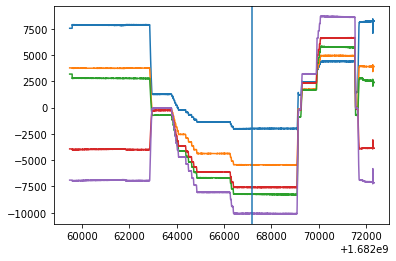

In [145]:
plt.plot(t, df_H[469])
plt.plot(t, df_H[470])
plt.plot(t, df_H[471])
plt.plot(t, df_H[472])
plt.plot(t, df_H[473])
plt.axvline(x=t[index])

In [146]:
x = df_H.iloc[index].T
y = df_V.iloc[index].T

df = pd.DataFrame()
df['X'] = x
df['Y'] = y
df['NAME'] = BPM_names_np

In [147]:
df1 = tfs.read('/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/MADX_thick/injection/all_optics_B1.tfs')
df1 = df1[df1.KEYWORD.str.contains('MONITOR')]
df1 = df1[['NAME', 'S']]
beam1 = pd.merge(df, df1, on='NAME')

df2 = tfs.read('/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/MADX_thick/injection/all_optics_B4.tfs')
df2 = df2[df2.KEYWORD.str.contains('MONITOR')]
df2 = df2[['NAME', 'S']]
beam2 = pd.merge(df, df2, on='NAME')

In [152]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=beam1.S, y=beam1.X/1e6, mode='lines', text = beam1.NAME, name='beam 1'))
fig.add_trace(go.Scatter(x=beam2.S, y=beam2.X/1e6, mode='lines', text = beam2.NAME, name='beam 2'))

fig.show()

In [153]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=beam1.S, y=beam1.Y/1e6, mode='lines', text = beam1.NAME, name='beam 1'))
fig.add_trace(go.Scatter(x=beam2.S, y=beam2.Y/1e6, mode='lines', text = beam2.NAME, name='beam 2'))

fig.show()